In [1]:
import pandas as pd
import pyarrow
import numpy as np
from scipy.spatial.distance import jensenshannon

In [2]:
work_languages_df = pd.read_parquet(
    '/run/media/rares17/f15020b9-f291-4fe9-85f0-e6bd87520125/thesis/bookdata-tools/book-links/deduced_languages.parquet',
    engine='pyarrow')
work_languages_df

,work_id,deduced_language
0,13595490,eng-original
1,28069067,other-translation-not-found
2,6832578,other-translated
3,26085788,unknown
4,16947674,eng-original
...,...,...
1521957,196000,unknown
1521958,1280700,eng-original
1521959,47330041,unknown
1521960,301191,eng-original


In [3]:
work_ratings_df = pd.read_parquet(
    '/run/media/rares17/f15020b9-f291-4fe9-85f0-e6bd87520125/thesis/bookdata-tools/goodreads/gr-work-ratings.parquet',
    engine='pyarrow')
work_ratings_df

,user,item,rating,last_rating,first_time,last_time,nratings
0,1,400625995,3.0,3.0,1501432064,1501432064,1
1,1,400033362,4.0,4.0,1495825408,1495825408,1
2,1,400985244,2.0,2.0,1490208512,1490208512,1
3,1,450247128,5.0,5.0,1488877696,1488877696,1
4,1,447250922,4.0,4.0,1482852608,1482852608,1
...,...,...,...,...,...,...,...
104028924,876145,403410520,3.0,3.0,1366579328,1366579328,1
104028925,876145,404812169,4.0,4.0,1366579328,1366579328,1
104028926,876145,421956106,3.0,3.0,1366579328,1366579328,1
104028927,876145,413086736,4.0,4.0,1367538688,1367538688,1


In [12]:
work_ratings_df['user'].value_counts()

user
320563    38402
257875    17183
69819     14137
438895    13018
56066     12980
          ...  
865768        1
872426        1
872405        1
872344        1
872328        1
Name: count, Length: 816371, dtype: int64

Nr. of users with 5 books read: 750205
Nr. of users with 10 books read: 701732


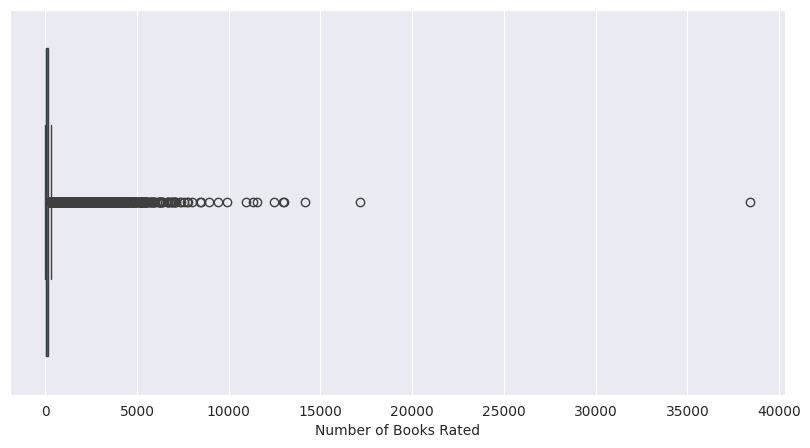

In [6]:
# check how many users have more than 5 and 10 books rated
user_counts = work_ratings_df['user'].value_counts()
# Filter out outlier users

print(f"Nr. of users with 5 books read: {len(user_counts[user_counts >= 5].index)}")
print(f"Nr. of users with 10 books read: {len(user_counts[user_counts >= 10].index)}")

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.boxplot(x=user_counts)

plt.xlabel("Number of Books Rated")

plt.show()

In [7]:
filtered_users = user_counts[user_counts <= 2500].index
filtered_df = work_ratings_df[work_ratings_df['user'].isin(filtered_users)]

/tmp/ipykernel_1885332/2233618566.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])


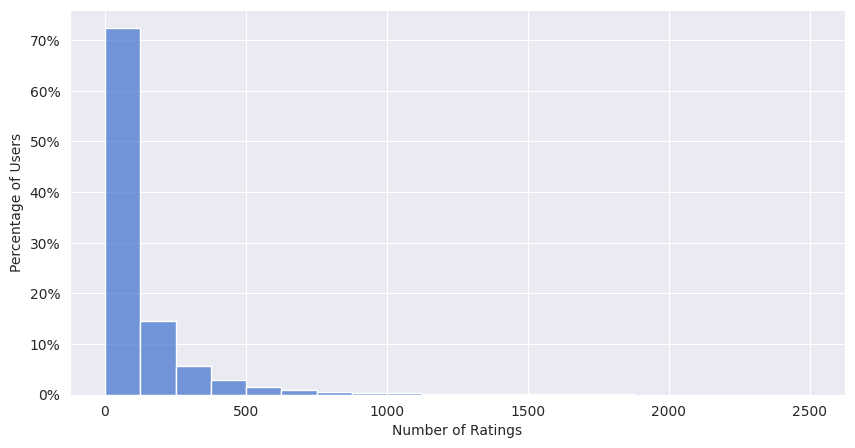

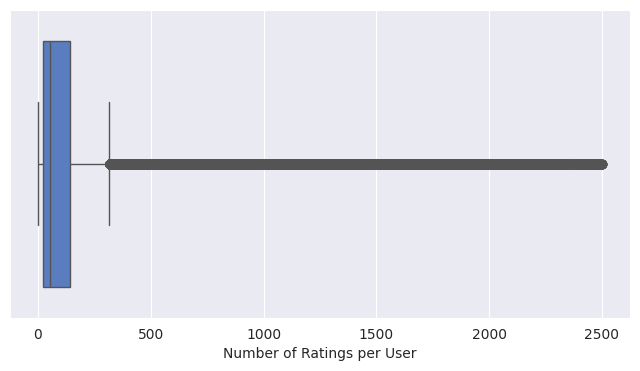

In [8]:

user_rating_counts = filtered_df.groupby('user').size()
colors = sns.color_palette("muted")
# Plot histogram
plt.figure(figsize=(10, 5))
ax = sns.histplot(user_rating_counts, bins=20, kde=False, stat="probability", color=colors[0])
plt.xlabel("Number of Ratings")
plt.ylabel("Percentage of Users")
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
plt.show()


# Plot boxplot to see outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=user_rating_counts, color=colors[0])
plt.xlabel("Number of Ratings per User")
plt.show()


In [17]:
Q1 = user_counts.quantile(0.15)
Q3 = user_counts.quantile(0.85)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

mean_count = user_counts.mean()
median_count = user_counts.median()
std_dev = user_counts.std()
max_count = user_counts.max()

print(f"Mean: {mean_count:.2f}, Median: {median_count:.2f}, Std Dev: {std_dev:.2f}")
print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Outlier threshold (Q3 + 1.5*IQR): {upper_bound:.2f}")
print(f"Max Ratings by a Single User: {max_count}")


Mean: 127.43, Median: 55.00, Std Dev: 236.36
Q1: 11.00, Q3: 226.00, IQR: 215.00
Outlier threshold (Q3 + 1.5*IQR): 548.50
Max Ratings by a Single User: 38402


# Generate similarity

In [2]:
import pandas as pd
gr_ratings_languages_df = pd.read_parquet(
    '/run/media/rares17/f15020b9-f291-4fe9-85f0-e6bd87520125/thesis/bookdata-tools/book-links/gr-item-rating-language.parquet',
    engine='pyarrow')
gr_ratings_languages_df

,user,item,rating,deduced_language
0,1,400625995,3,ambiguous
1,1,400033362,4,other-translated
2,1,400985244,2,other-translated
3,1,450247128,5,other-translated
4,1,447250922,4,other-translated
...,...,...,...,...
104028924,876145,403410520,3,unknown
104028925,876145,404812169,4,other-translation-not-found
104028926,876145,421956106,3,other-translation-not-found
104028927,876145,413086736,4,unknown


In [3]:
user_counts = gr_ratings_languages_df['user'].value_counts()
filtered_users = user_counts[(user_counts >= 11) & (user_counts <= 2500)].index
filtered_users

Index([368439, 345286,  62459, 155965, 224232, 158821, 136908, 116293, 305401,
       108445,
       ...
       825562, 851298, 663283, 861916, 454814, 743551, 840645, 629916, 778599,
       717952],
      dtype='uint32', name='user', length=693572)

In [4]:
gr_ratings_languages_df = gr_ratings_languages_df[gr_ratings_languages_df['user'].isin(filtered_users)]
gr_ratings_languages_df

,user,item,rating,deduced_language
0,1,400625995,3,ambiguous
1,1,400033362,4,other-translated
2,1,400985244,2,other-translated
3,1,450247128,5,other-translated
4,1,447250922,4,other-translated
...,...,...,...,...
104028924,876145,403410520,3,unknown
104028925,876145,404812169,4,other-translation-not-found
104028926,876145,421956106,3,other-translation-not-found
104028927,876145,413086736,4,unknown


In [5]:
language_counts = gr_ratings_languages_df.groupby(['user', 'deduced_language']).size().reset_index(name='count')
language_counts

,user,deduced_language,count
0,1,ambiguous,169
1,1,eng-original,120
2,1,other-translated,175
3,1,unknown,8
4,2,ambiguous,34
...,...,...,...
2784524,876145,ambiguous,1
2784525,876145,eng-original,1
2784526,876145,other-translated,6
2784527,876145,other-translation-not-found,13


In [6]:
total_counts = gr_ratings_languages_df.groupby('user').size().reset_index(name='total')
total_counts

,user,total
0,1,472
1,2,99
2,3,190
3,4,41
4,5,176
...,...,...
693567,876141,11
693568,876142,11
693569,876143,32
693570,876144,23


In [7]:
del gr_ratings_languages_df

In [8]:
language_ratios = language_counts.merge(total_counts, on='user')
language_ratios['ratio'] = language_ratios['count'] / language_ratios['total']

pivot_ratios = language_ratios.pivot(index='user', columns='deduced_language', values='ratio').fillna(0)
pivot_ratios

deduced_language,ambiguous,eng-original,other-translated,other-translation-not-found,unknown
user,,,,,
1,0.358051,0.254237,0.370763,0.000000,0.016949
2,0.343434,0.232323,0.282828,0.000000,0.141414
3,0.252632,0.300000,0.447368,0.000000,0.000000
4,0.170732,0.390244,0.414634,0.000000,0.024390
5,0.232955,0.215909,0.528409,0.000000,0.022727
...,...,...,...,...,...
876141,0.454545,0.272727,0.272727,0.000000,0.000000
876142,0.363636,0.272727,0.363636,0.000000,0.000000
876143,0.562500,0.062500,0.375000,0.000000,0.000000


In [11]:
reference_proportions = np.array([0.016962, 0.319142, 0.091811, 0.031959, 0.540126]) # ambiguous eng-org other-translated other-translation-not-found unknown
pivot_ratios = pivot_ratios[['ambiguous', 'eng-original', 'other-translated', 'other-translation-not-found', 'unknown']]
pivot_ratios

deduced_language,ambiguous,eng-original,other-translated,other-translation-not-found,unknown
user,,,,,
1,0.358051,0.254237,0.370763,0.000000,0.016949
2,0.343434,0.232323,0.282828,0.000000,0.141414
3,0.252632,0.300000,0.447368,0.000000,0.000000
4,0.170732,0.390244,0.414634,0.000000,0.024390
5,0.232955,0.215909,0.528409,0.000000,0.022727
...,...,...,...,...,...
876141,0.454545,0.272727,0.272727,0.000000,0.000000
876142,0.363636,0.272727,0.363636,0.000000,0.000000
876143,0.562500,0.062500,0.375000,0.000000,0.000000


In [14]:
js_divergences = pivot_ratios.apply(lambda row: jensenshannon(row, reference_proportions, base=2), axis=1)
js_divergences

user
1         0.667178
2         0.527601
3         0.683722
4         0.601165
5         0.662360
            ...   
876141    0.710127
876142    0.700171
876143    0.809356
876144    0.634398
876145    0.478790
Length: 693572, dtype: float64

/tmp/ipykernel_1873029/4106129147.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax=sns.histplot(js_divergences, bins=10, kde=False, stat="probability", palette="muted")
/tmp/ipykernel_1873029/4106129147.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])


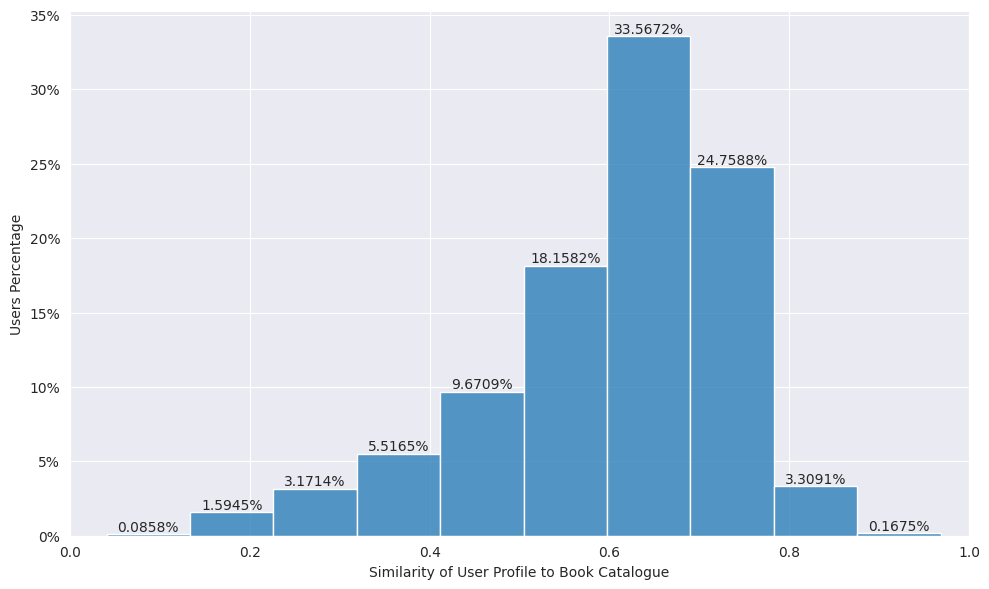

user
1         0.667178
2         0.527601
3         0.683722
4         0.601165
5         0.662360
            ...   
876141    0.710127
876142    0.700171
876143    0.809356
876144    0.634398
876145    0.478790
Length: 693572, dtype: float64


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax=sns.histplot(js_divergences, bins=10, kde=False, stat="probability", palette="muted")

# Add labels
plt.xlabel("Similarity of User Profile to Book Catalogue")
plt.ylabel("Users Percentage")

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.4%}',  # Convert to percentage format
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the text
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        xytext=(0, 5),  # Offset from the bar
        textcoords='offset points',
    )
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
# Show the plot
plt.xlim(0, 1)
plt.tight_layout()
plt.show()
print(js_divergences)

/tmp/ipykernel_1873029/3062998844.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax=sns.histplot(js_divergences, bins=10, kde=False, stat="probability", palette="muted")
/tmp/ipykernel_1873029/3062998844.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])


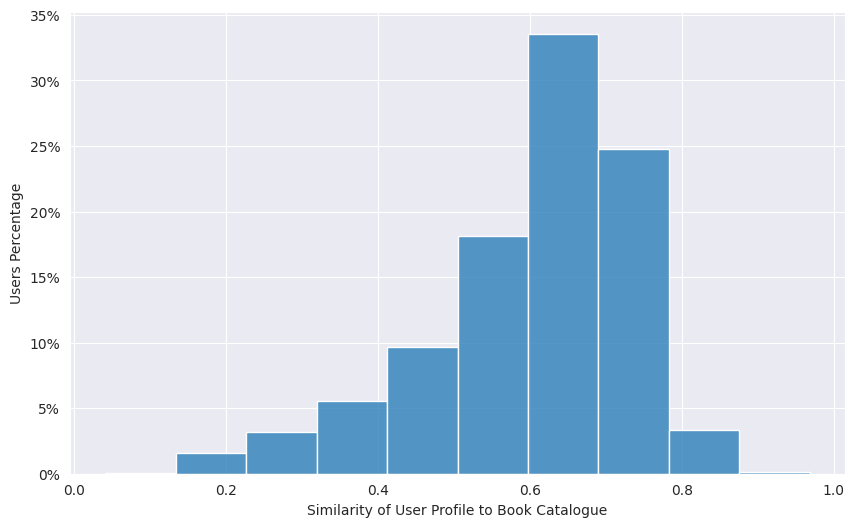

user
1         0.667178
2         0.527601
3         0.683722
4         0.601165
5         0.662360
            ...   
876141    0.710127
876142    0.700171
876143    0.809356
876144    0.634398
876145    0.478790
Length: 693572, dtype: float64


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax=sns.histplot(js_divergences, bins=10, kde=False, stat="probability", palette="muted")

# Add labels
plt.xlabel("Similarity of User Profile to Book Catalogue")
plt.ylabel("Percentage of Users")
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
plt.show()
print(js_divergences)